<a href="https://colab.research.google.com/github/melipass/pcp-datos-cosmologicos/blob/main/share_sesion1_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://habrastorage.org/webt/jq/gc/r5/jqgcr5azmatev6zvgufn8xftehy.png">
    

    
# Análisis de datos cosmológicos y el problema de la constante de Hubble usando Python

### Autor: David F. Camarena Torres

# <center> Sesión 1.2 Local determination of the Hubble constant and the deceleration parameter
[arXiv:1906.11814](https://arxiv.org/abs/1906.11814)    


# Outline
1. [Magnitud absoluta de Supernovas](#1.-MB)
2. [Analises SH0ES](#2.-SH0ES)
3. [Determinacion local de $H_0$ y $q_0$](#3.-H0/q0)

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/23/Cosmic_distance_ladder.jpg">

## 1.-MB

Observacion de la curva de luz de supernovas del Tipo Ia permite determinar $m_B$ 

Necesitan ser calibradras para ofrecer distancias cosmologicas:

$$m_B(z) = 5\log_{10}\frac{d_L(z)}{\rm 1 Mpc}+25 + M_B$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

plt.rcParams['font.size'] = '18'

In [2]:
! pip install gdown
import os 
if not 'datos_sesion1-2.tar.gz' in os.listdir():
  ! gdown --id 1Xiw04RSjKvdOjLB7BQxFNVgH54yh5RRp --output datos_sesion1-2.tar.gz
  ! tar -xvf datos_sesion1-2.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1Xiw04RSjKvdOjLB7BQxFNVgH54yh5RRp
To: /content/datos_sesion1-2.tar.gz
100% 172k/172k [00:00<00:00, 5.24MB/s]
datos_sesion1-2/
datos_sesion1-2/Pantheon-low/
datos_sesion1-2/Pantheon-low/cov_low-sne.dat
datos_sesion1-2/Pantheon-low/low-sne.txt


In [3]:
sne_datos = pandas.read_table('datos_sesion1-2/Pantheon-low/low-sne.txt',sep='\t')

cov_sne = pandas.read_table('datos_sesion1-2/Pantheon-low/cov_low-sne.dat')
cov_sne = np.array(cov_sne).reshape((237, 237))

sne_datos.head()

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
0,06D2fb,0.12531,0.12531,0.0,19.46840,0.10355,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,744,0.12679,0.12679,0.0,19.54290,0.11965,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2,1241,0.08859,0.08859,0.0,18.64345,0.10605,0,0,0,0,0,0,0,0,0,0,0,0,NaN
3,1371,0.11782,0.11782,0.0,19.19345,0.09910,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,1794,0.14055,0.14055,0.0,19.87100,0.11635,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [4]:
z_sne = np.array(sne_datos['zcmb'])
mb_sne = np.array(sne_datos['mb'])
dmb_sne = np.array(sne_datos['dmb'])

# z_sne = sne_datos['zcmb']
# mb_sne = sne_datos['mb']
# dmb_sne = sne_datos['dmb']

cov_sne_tot = cov_sne + np.diag(sne_datos['dmb'])**2
inv_cov_sne = np.linalg.inv(cov_sne_tot)

print('zmin, zmax: %.4f, %.4f'%(np.min(z_sne),np.max(z_sne)))

zmin, zmax: 0.0235, 0.1495


Asumiendo un prior Gaussiano en $M_B = \mathcal{N}\left({\hat{M}_B,\sigma_{M}}\right)$ y dada la forma espcial de la likelihood es posible convertir la posterior en $H_0$ en un prior en $M_B$

$$\hat{H}_0 = \exp(\mu_{\ln} + 0.5\sigma^2_{\ln})$$

$$\sigma_H = \exp(2\mu_{\ln} + \sigma^2_{\ln})\left(\exp \sigma^2_{\ln} - 1\right)$$

$$ \mu_{\ln} = \frac{\ln 10}{5} \left[ \hat{M}_B + \frac{\ln(10)}{5} \left( \sigma^2_M + \frac{1}{S_0} \right) - \frac{S_1}{S_0} \right]$$

$$ \sigma_{\ln} =\frac{\ln 10}{5} \sqrt{\sigma^2_M + \frac{1}{S_0}}$$

Donde $S_0$ y $S_1$ siguen:

$$S_0 = V_i C^{-1}_{ij} V_j \,, \,\,\,\, S_1= W_i C^{-1}_{ij} V_j$$

$$W_i = m_{B,i} - x_B(z_i)\,,\,\,\, V_i = 1 \,,\,\, x_B(z_i) = 5\log_{10}\left(cz\left[1+\frac{1}{2}(1-q_0)z-\frac{1}{6}(1-q_0-3q_0^2+j_0)z^2\right]\right)+25$$

Nota: $S_1$ y $S_0$ están relacionados al catálogo de supernovas que estamos usando.

In [5]:
from scipy import constants
cc = constants.c/1000.

Calcula $S_0$ y $S_1$

In [13]:
def mBtilde(z):
  q0 = -0.55
  j0 = 1.
  term1 = 0.5*(1-q0)*z
  term2 = -(1 - q0 - 3*q0**2 * j0)*z**2/6.
  mBt = 5*np.log10(cc*z*(1+term1+term2))+25
  return mBt

In [14]:
V_i = np.ones(len(inv_cov_sne))
S0 = np.dot(np.dot(V_i, inv_cov_sne),V_i)
W_i = mb_sne - mBtilde(z_sne)
# W_i es la diferencia entre la magnitud absoluta
# observada de supernovas menos la función definida arriba
S1 = np.dot(np.dot(W_i, inv_cov_sne),V_i)
print(S0,S1)

10689.40997018274 -305377.72832762933


Usando como posterior $H_0 = \mathcal{N}({73.5,1.4})$ [Ried et al., 2019](https://arxiv.org/abs/1908.05625) calcula el prior en $M_B$

In [15]:
H0_ini = 73.5 # asumimos este valor como media
sig_H0_ini = 1.4 # desviación estándar

In [30]:
def mu_lnH(MB_p, sigma_M_p):
    mu = 0.2*np.log(10)*(MB_p - S1/S0 + (1/S0 + sigma_M_p**2)*0.2*np.log(10))
    return mu

In [31]:
def sigma_lnH(MB_p,sigMB_p):
  sig = np.log(10)/5 * np.sqrt(sigMB_p**2+1./S0)
  return sig

In [32]:
def media_H(MB_p, sigma_M_p):
    mean = np.exp(mu_lnH(MB_p, sigma_M_p) + 0.5*sigma_lnH(MB_p, sigma_M_p)**2)
    return mean

def varia_H(MB_p, sigma_M_p):
    var = np.exp(2*mu_lnH(MB_p, sigma_M_p)+sigma_lnH(MB_p, sigma_M_p)**2)*(-1+np.exp(sigma_lnH(MB_p, sigma_M_p)**2))
    return var

In [33]:
def sol_MB_prior(vec):
  MB_p, sigM_p = vec
  ecua1 = media_H(MB_p, sigM_p) - H0_ini
  ecua2 = varia_H(MB_p, sigM_p) - sig_H0_ini**2 # como se trata de la varianza, tiene que ser al cuadrado
  return [ecua1, ecua2]

In [34]:
from scipy import optimize
MB_fin, sigma_MB_fin = optimize.fsolve(sol_MB_prior,[-19,0.04])

In [35]:
print(MB_fin,sigma_MB_fin)

-19.237994090579587 0.0402107310462513


$$p(M_B) = \mathcal{N} (-19.234,0.0402)$$

## 2.-SH0ES

Analisis independiente del modelo a traves de expansion cosmografica ([gr-qc/0411131](https://arxiv.org/abs/gr-qc/0411131)):

$$d_L(z) = \frac{cz}{H_0} \left\lbrace 1+\frac{1}{2}(1-q_0)z-\frac{1}{6}(1-q_0-3q_0^2+j_0)z^2 + \mathcal{O}(z^3) \right\rbrace$$

$$m_B(z) = m_B(z,H_0,q_0,j_0,...)$$

Analisis de SH0ES asume $q_0 = -0.55$ y $j_0 = 1.$ (valores obtenidos con $\Lambda$CDM)

In [98]:
def cosmografia_dL(z, H0, q0, j0=None):
  term1 = 0.5*(1.-q0)*z
  if j0 == None:
    term2 = 0.
  else:
    term2 = -(1.0 - q0-3*q0**2+j0)*z**2/6.
  dL = cc*z*(1+term1+term2)/H0 # cc es la velocidad de la luz en el vacio, z el redshift
  return dL

In [40]:
cosmografia_dL(z=0.5, H0=70, q0=-0.5, j0=1.0) # probando la función

2788.2483072916666

In [42]:
def cosmografia_mB_sh0es(vec):
  H0, MB = vec
  # usaremos los valores dados
  q0 = -0.55
  j0 = 1.0
  # vamos a observar el redshift de supernovas, por lo tanto usaremos z_sne
  cosmom = 5*np.log10(cosmografia_dL(z_sne,H0,q0,j0)) + 25 + MB
  return cosmom

Define la distancia de luminosidad usando la expansion cosmografica. Realiza un grafico para redshifts $z = [0.,0.15]$ considerando dos casos $\left\lbrace q_0 = -0.55, j0 = 1\right\rbrace$ y $\left\lbrace  q_0 = -0.75, j_0 = 1.2\right\rbrace$ ($H_0 = 70$ para ambos casos)

Text(0, 0.5, '$m_B(z)$')

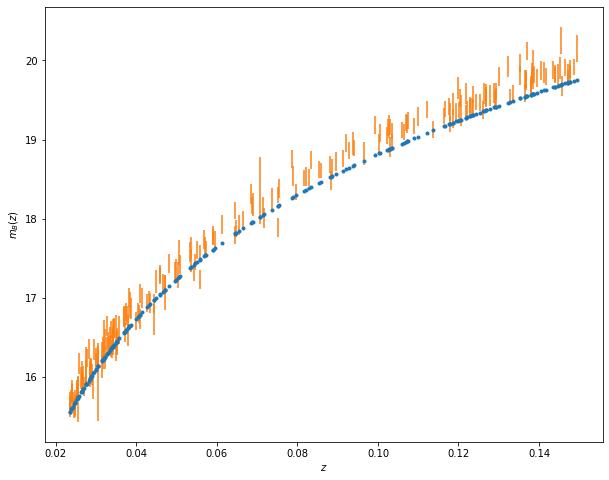

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(z_sne,cosmografia_mB_sh0es([70.,-19.5]),'.')
ax.errorbar(z_sne,mb_sne,dmb_sne,ls=' ')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$m_B(z)$')

Construye $\chi^2$ para supernovas usando la expansion cosmografica. Calcula el caso de $H_0 = 73$, $q_0 = -0.55$ y $j_0 = 1.$

In [45]:
def chi2_sn(theta_vec):
  mB_theo = cosmografia_mB_sh0es(theta_vec)
  diff = mb_sne - mB_theo
  chi2sn = np.dot(np.dot(diff,inv_cov_sne),diff)
  return chi2sn

log_lkl_sn = lambda theta_vec: -0.5*chi2_sn(theta_vec)

In [46]:
chi2_sn([70.,-19])

1467.0664941247

In [47]:
def log_prior_MB(theta_vec):
  H0, MB = theta_vec
  logpM = -0.5*(MB-MB_fin)**2/sigma_MB_fin**2
  return logpM

In [50]:
H0max = 78
H0min = 64
MBmin = -19.7
MBmax = -18.8

def log_flat_prior(theta_vec):
  H0, MB = theta_vec
  if not (H0min <= H0 <= H0max):
    return -np.inf
  elif not (MBmin <= MB <= MBmax):
    return -np.inf
  else:
    return 0.0

def log_likelihood(theta_vec):
  H0,MB = theta_vec
  loglikelihood = log_lkl_sn(theta_vec) + log_flat_prior(theta_vec) + log_prior_MB(theta_vec)
  return loglikelihood

In [51]:
log_likelihood([H0min-1e-12, MBmin-1e-12]),log_likelihood([H0max+1e-12,MBmax+1e-12])

(-inf, -inf)

In [53]:
primer_bf = np.array([73.5,-19.4])
%timeit log_likelihood(primer_bf)

The slowest run took 37.87 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 76.3 µs per loop


In [54]:
%timeit chi2_sn(primer_bf)

The slowest run took 19.14 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 63.8 µs per loop


## 2.a- emcee: Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler 
[Codigo disponible aqui](https://emcee.readthedocs.io/en/stable/)

<center>
<img src="https://miro.medium.com/max/1838/1*QdYUe-nZYZnOfj_Oqt9CHw.jpeg">

In [55]:
! pip install emcee
import emcee

ncaminantes = 32
npasos = 50000 # 250000
burn_in = 500 #burn_in son los posibles puntos, y vamos a comenzar con un punto aleatorio

punto_ini = primer_bf + 1e-3*np.random.randn(ncaminantes, len(primer_bf))

     |████████████████████████████████| 51kB 6.6MB/s 


In [57]:
punto_ini # estos son los puntos de partida, muy próximos al best fit

array([[ 73.49940616, -19.4002484 ],
       [ 73.49971302, -19.39997472],
       [ 73.50123362, -19.39872076],
       [ 73.49641528, -19.39976233],
       [ 73.49907805, -19.40055287],
       [ 73.49965763, -19.40134877],
       [ 73.49971245, -19.39916168],
       [ 73.49993171, -19.4007383 ],
       [ 73.50078356, -19.40042634],
       [ 73.50129338, -19.40015936],
       [ 73.50042978, -19.39808286],
       [ 73.49866863, -19.40055598],
       [ 73.49995407, -19.40030712],
       [ 73.4997396 , -19.39987934],
       [ 73.49979579, -19.39852249],
       [ 73.49980647, -19.40059972],
       [ 73.50074547, -19.40179794],
       [ 73.50094041, -19.40177531],
       [ 73.50090904, -19.39933935],
       [ 73.49852213, -19.4001222 ],
       [ 73.4980445 , -19.39763576],
       [ 73.50078624, -19.40060502],
       [ 73.49995615, -19.39926054],
       [ 73.49914619, -19.4017326 ],
       [ 73.5003603 , -19.40322541],
       [ 73.50005001, -19.39918262],
       [ 73.49939853, -19.39977573],
 

In [58]:
sampler_shoes = emcee.EnsembleSampler(ncaminantes, 2, log_likelihood) # 2 parámetros libres

nuevo_ini = sampler_shoes.run_mcmc(punto_ini, burn_in)
sampler_shoes.reset()

In [61]:
nuevo_ini.coords #será nuestro nuevo punto de partida para nuestros caminantes
# los valores iniciales están más cerca del resultado final

array([[ 73.01779389, -19.25631011],
       [ 74.9899794 , -19.1929171 ],
       [ 73.0279063 , -19.24224505],
       [ 71.13455475, -19.30458887],
       [ 71.884531  , -19.25429247],
       [ 73.28330461, -19.23961116],
       [ 72.78563519, -19.26422061],
       [ 73.42882903, -19.23223287],
       [ 72.20420494, -19.27230418],
       [ 71.26187047, -19.30237093],
       [ 76.10571736, -19.14601422],
       [ 74.42588052, -19.20415009],
       [ 76.76767237, -19.14575266],
       [ 73.33683639, -19.24235075],
       [ 72.76168403, -19.25153529],
       [ 75.46430307, -19.16213343],
       [ 69.7119394 , -19.34854265],
       [ 73.8127519 , -19.23149083],
       [ 75.26175843, -19.19196801],
       [ 72.56769844, -19.25292379],
       [ 74.6471936 , -19.19964081],
       [ 73.99103841, -19.21375993],
       [ 75.23800116, -19.1799125 ],
       [ 70.43295911, -19.32166304],
       [ 73.29639832, -19.23097198],
       [ 75.52753097, -19.17027721],
       [ 73.94315312, -19.21907844],
 

In [72]:
import time

t0 = time.time()

sampler_shoes.run_mcmc(nuevo_ini, npasos)

t1 = time.time()
(t1-t0)/60

3.0342817306518555

In [73]:
sampler_shoes.get_chain(flat=True,thin=2).shape

(2272896, 2)

In [74]:
samples_shoes = sampler_shoes.get_chain(flat=True,thin=2)
loglikes_shoes = sampler_shoes.get_log_prob(flat=True,thin=2)

## 2.b- GetDist: Python package for analysing and plotting MonteCarlo samples
[Codigo disponible aqui](https://getdist.readthedocs.io/en/latest/)

<center>
<img src="https://www.leansixsigmadefinition.com/wp-content/uploads/2019/10/six_sigma_definition_standard_deviations.jpg">

In [75]:
! pip install getdist
import getdist
from getdist import plots, MCSamples
samp_shoes = getdist.mcsamples.MCSamples(samples=samples_shoes, names = ['H0','MB'], labels = ['H_0','M_B'])

samp_shoes.updateSettings({'contours': [0.682689492137086, 0.954499736103642,0.997300203936740]})

Removed no burn in


(2, 1)

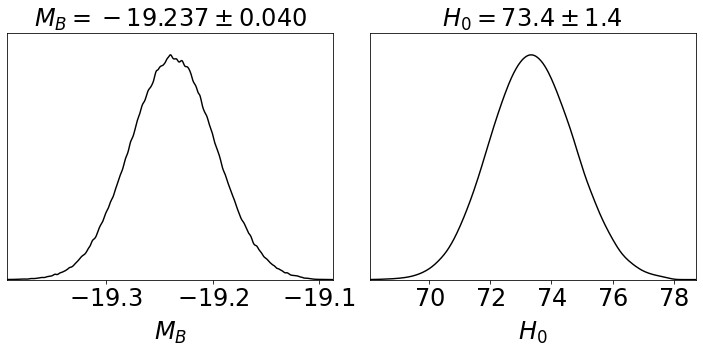

In [76]:
g = plots.get_subplot_plotter(width_inch=10,)
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 24
g.settings.axes_labelsize = 24

g.plots_1d(samp_shoes,['MB','H0'],nx=2, title_limit=1)

((68.05816419616156, 78.72001685191587),
 (-19.393080671337767, -19.08639165256723))

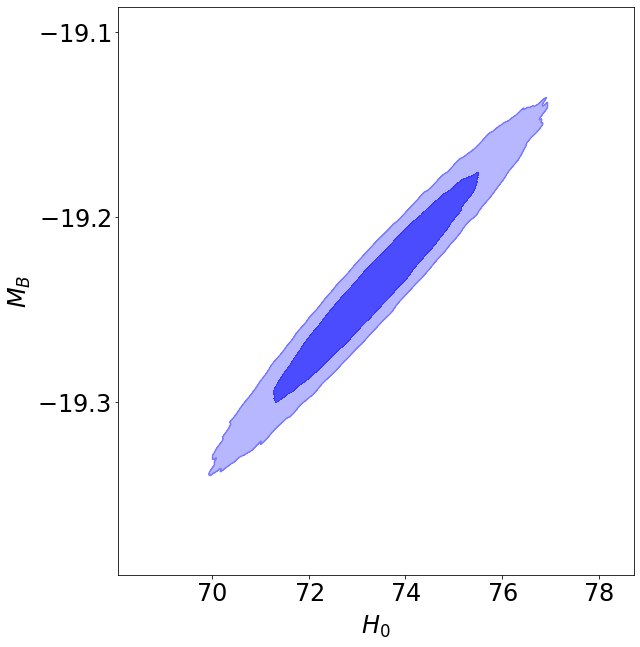

In [77]:
g = plots.get_single_plotter(width_inch=9,ratio=1.01)
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 24
g.settings.axes_labelsize = 24

g.plot_2d(samp_shoes, 'H0', 'MB', filled=True, colors=['blue'], alphas=[0.7,0.6])

In [78]:
stat = samp_shoes.getMargeStats()
print(stat)

Marginalized limits: 0.682689492137086; 0.954499736103642; 0.99730020393674

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
H0          7.3387126E+01  1.3936323E+00  7.1990431E+01  7.4787221E+01  two    7.0646512E+01  7.6210596E+01  two    6.9309392E+01  7.7529585E+01  two     H_0
MB         -1.9237314E+01  4.0054276E-02 -1.9277465E+01 -1.9197163E+01  two   -1.9317228E+01 -1.9157046E+01  two   -1.9357247E+01 -1.9120582E+01  two     M_B



<Figure size 720x727.2 with 0 Axes>

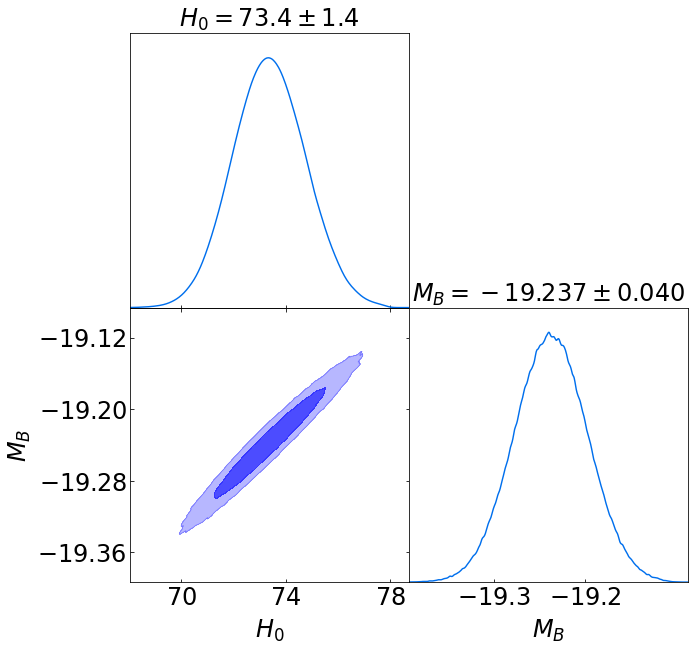

In [79]:
g = plots.get_single_plotter(width_inch=10,ratio=1.01)
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 24
g.settings.axes_labelsize = 24

g.triangle_plot(samp_shoes, ['H0', 'MB'], filled=True, colors=['blue'], alphas=[0.7,0.6],title_limit=1,)

## 3.-H0/q0

Nuestro analisis asume $q_0$ libre y $d_L(z)$ hasta $\mathcal{O}(z^2)$

$$d_L(z) = \frac{cz}{H_0} \left\lbrace 1+\frac{1}{2}(1-q_0)z \right\rbrace$$



Repetir analisis para este caso

In [80]:
# Sigue los pasos:
# 1.- Generaliza cosmografia_mB_sh0es (cosmografia_mB) de tal manera que la nueva funcion
# tenga como argumento un vector [H0,q0,MB]
# 2.- Actualiza chi2_sn([H0,q0,MB]) de manera que ahora use cosmografia_mB
# 3.- Actualiza log_flat_prior([H0,q0,MB]) usando q0min = -2.5, q0max = 0.5 
# 4.- Reconstruye log_likelihood([H0,q0,MB])

In [91]:
def cosmografia_mB(theta_vec):
  H0, q0, MB = theta_vec
  dL = cosmografia_dL(z_sne,H0,q0)
  mB = 5*np.log10(dL) + 25 +MB
  return mB

In [92]:
from numba import jit

In [93]:
@jit(forceobj=True)
def chi2_sn(theta_vec):
    mB_theo = cosmografia_mB(theta_vec)
    diff = mb_sne - mB_theo
    chi2sn = np.dot(np.dot(diff,inv_cov_sne),diff)
    return chi2sn

log_lkl_sn = lambda theta_vec: -0.5*chi2_sn(theta_vec)

In [94]:
H0max = 83
H0min = 64
MBmin=-19.7
MBmax=-18.8
q0min = -2.5
q0max = 0.5 

def log_prior_MB(theta_vec):
  H0, q0, MB = theta_vec
  logpM = -0.5*(MB-MB_fin)**2/sigma_MB_fin**2
  return logpM


def log_flat_prior(theta_vec):
    H0, q0, MB = theta_vec
    if not (H0min<=H0<=H0max):
        return -np.inf
    elif not (MBmin<=MB<=MBmax):
        return -np.inf
    elif not (q0min<=q0<=q0max):
        return -np.inf
    else:
        return 0.0

def log_likelihood(theta_vec):
    H0, q0, MB=theta_vec
    loglikelihood = log_lkl_sn(theta_vec) + log_flat_prior(theta_vec) + log_prior_MB(theta_vec)
    return loglikelihood

In [99]:
log_likelihood([H0min-1e-12,q0min-1e-12,MBmin-1e-12]),log_likelihood([H0max+1e-12,q0max+1e-12,MBmax+1e-12])

(-inf, -inf)

In [100]:
primer_bf = np.array([73.5,-0.55,-19.4])

ncaminantes = 32
npasos = 20000 # 250000
burn_in = 500

punto_ini = primer_bf + 1e-3*np.random.randn(ncaminantes, len(primer_bf))

In [101]:
sampler = emcee.EnsembleSampler(ncaminantes, 3, log_likelihood)

nuevo_ini = sampler.run_mcmc(punto_ini, burn_in)
sampler.reset()

In [102]:
t0 = time.time()

sampler.run_mcmc(nuevo_ini, npasos)

t1 = time.time()
(t1-t0)/60

1.1825662493705749

In [103]:
samples = sampler.get_chain(flat=True,thin=2)
loglikes = sampler.get_log_prob(flat=True,thin=2)

In [104]:
import getdist
from getdist import plots, MCSamples
samp = getdist.mcsamples.MCSamples(samples=samples, names = ['H0','q0','MB'], labels = ['H_0','q_0','M_B'])

samp.updateSettings({'contours': [0.682689492137086, 0.954499736103642,0.997300203936740]})

Removed no burn in


In [105]:
stat = samp.getMargeStats()
print(stat)

Marginalized limits: 0.682689492137086; 0.954499736103642; 0.99730020393674

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
H0          7.5171640E+01  1.6681765E+00  7.3508976E+01  7.6847377E+01  two    7.1897597E+01  7.8566890E+01  two    7.0352029E+01  8.0270635E+01  two     H_0
q0         -1.0816703E+00  2.8679392E-01 -1.3696620E+00 -7.9466870E-01  two   -1.6626653E+00 -5.1652618E-01  two   -1.9553198E+00 -2.4079075E-01  two     q_0
MB         -1.9237510E+01  3.9964993E-02 -1.9277412E+01 -1.9197534E+01  two   -1.9317055E+01 -1.9157079E+01  two   -1.9357418E+01 -1.9116951E+01  two     M_B



<Figure size 720x727.2 with 0 Axes>

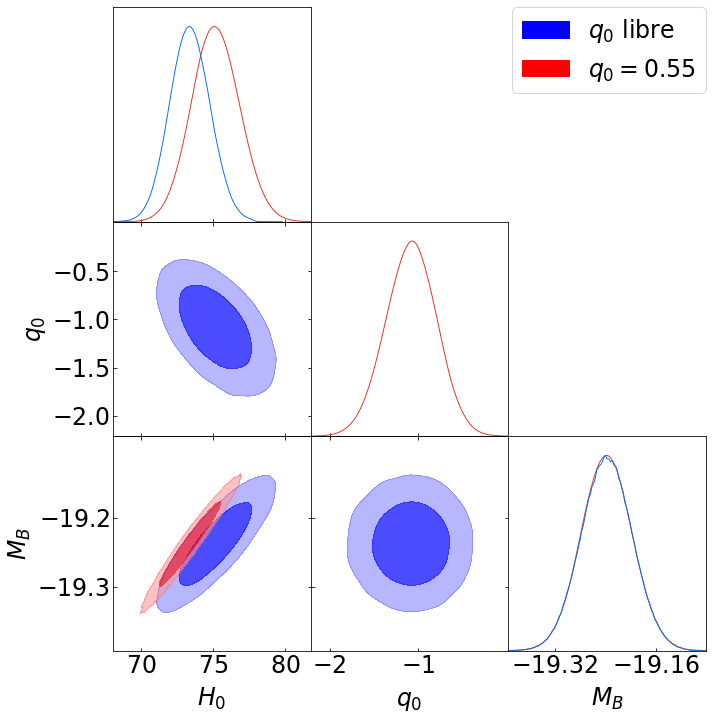

In [106]:
g = plots.get_single_plotter(width_inch=10,ratio=1.01)
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 24
g.settings.axes_labelsize = 24

g.triangle_plot([samp,samp_shoes], ['H0','q0', 'MB'], filled=True, colors=['blue','red'], alphas=[0.7,0.6],legend_labels=[r'$q_0$ libre',r'$q_0=0.55$'])

Reproducir Fig.1 de [arXiv:1906.11814](https://arxiv.org/abs/1906.11814)    

In [107]:
# Hacer un histograma y graficar la diferencia entre la ecuacion cosmografica 1er y 2do orden

Analizar $\Lambda$CDM con CC y SNe (sesion 1.1) usando emcee y getdsit.

In [108]:
# Realizar lo de la clase anterior con emcee y getdsit